In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pydaptivefiltering as pdf

In [2]:
# --- CONFIGURAÇÃO DO AMBIENTE ---
np.random.seed(42)
n_samples = 2500

# 1. Definição da Planta IIR "Desconhecida"
# H(z) = (0.3 + 0.1z^-1) / (1 - 0.9z^-1 + 0.2z^-2)
b_true = np.array([0.3, 0.1])
a_true_vals = np.array([0.9, -0.2]) # Representando -a1 e -a2 no vetor w

zeros_order = len(b_true) - 1
poles_order = len(a_true_vals)

# 2. Geração de Sinais
x = np.random.randn(n_samples) # Entrada: Ruído Branco
# d[k] é a saída da planta com ruído de medição
d_clean = signal.lfilter(b_true, np.insert(-a_true_vals, 0, 1.0), x)
d = d_clean + 0.05 * np.random.randn(n_samples)

In [3]:
# --- INICIALIZAÇÃO DO FILTRO RLSIIR ---
# forgetting_factor: tipicamente entre 0.95 e 1.0
# delta: regularização da matriz Sd (inversa da autocorrelação)
rls_iir = pdf.RLSIIR(
    zeros_order=zeros_order,
    poles_order=poles_order,
    forgetting_factor=0.995,
    delta=0.01
)

# --- EXECUÇÃO DA OTIMIZAÇÃO ---
result = rls_iir.optimize(
    input_signal=x, 
    desired_signal=d, 
    verbose=True, 
    return_internal_states=True
)

[RLSIIR] Completed in 75.51 ms


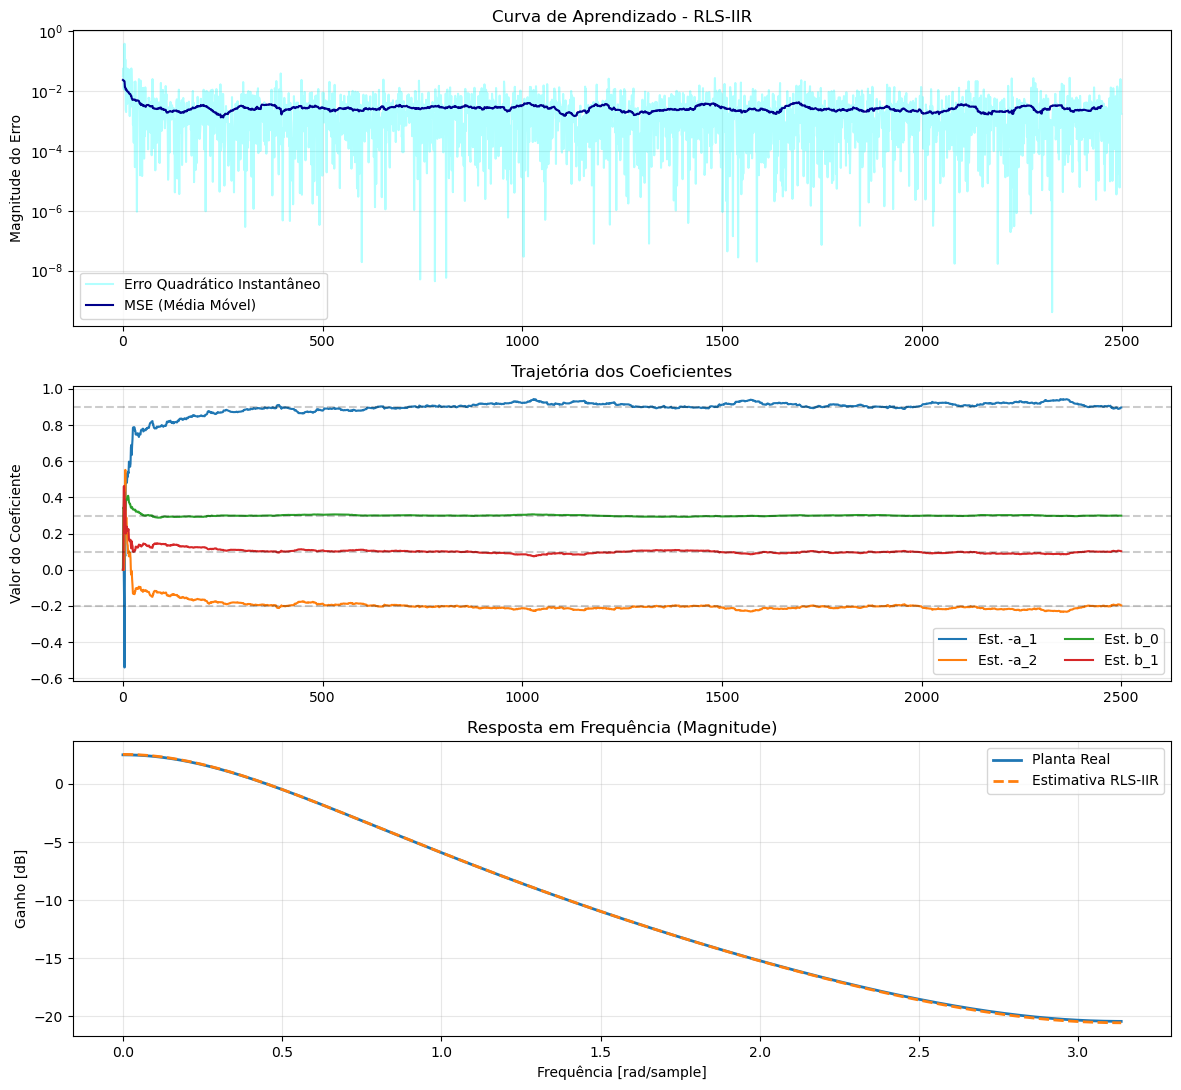

Coeficientes Finais: [ 0.89694775 -0.19692328  0.29918003  0.10256325]


In [4]:
# --- VISUALIZAÇÃO DOS RESULTADOS ---
plt.figure(figsize=(12, 11))

# 1. MSE (Learning Curve)
plt.subplot(3, 1, 1)
mse = result.errors**2
plt.semilogy(mse, label='Erro Quadrático Instantâneo', color='cyan', alpha=0.3)
plt.semilogy(np.convolve(mse, np.ones(50)/50, mode='valid'), label='MSE (Média Móvel)', color='darkblue')
plt.title('Curva de Aprendizado - RLS-IIR')
plt.ylabel('Magnitude do Erro')
plt.grid(True, which='both', alpha=0.3)
plt.legend()

# 2. Evolução dos Pesos (Convergência)
plt.subplot(3, 1, 2)
w_history = np.array(result.coefficients)
labels = [f'-a_{i+1}' for i in range(poles_order)] + [f'b_{i}' for i in range(zeros_order + 1)]
for i in range(rls_iir.n_coeffs):
    plt.plot(w_history[:, i], label=f'Est. {labels[i]}')
    
    # Valores reais para comparação
    ref = a_true_vals[i] if i < poles_order else b_true[i - poles_order]
    plt.axhline(y=ref, color='black', linestyle='--', alpha=0.2)

plt.title('Trajetória dos Coeficientes')
plt.ylabel('Valor do Coeficiente')
plt.legend(ncol=2)
plt.grid(True, alpha=0.3)

# 3. Resposta em Frequência (Final)
plt.subplot(3, 1, 3)
w_final = rls_iir.w
a_est = w_final[:poles_order]
b_est = w_final[poles_order:]

w_f, h_true = signal.freqz(b_true, np.insert(-a_true_vals, 0, 1.0))
_, h_est = signal.freqz(b_est, np.insert(-a_est, 0, 1.0))

plt.plot(w_f, 20 * np.log10(np.abs(h_true)), label='Planta Real', lw=2)
plt.plot(w_f, 20 * np.log10(np.abs(h_est)), '--', label='Estimativa RLS-IIR', lw=2)
plt.title('Resposta em Frequência (Magnitude)')
plt.xlabel('Frequência [rad/sample]')
plt.ylabel('Ganho [dB]')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Coeficientes Finais: {rls_iir.w}")